In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


In [2]:
strava_data = pd.read_csv('raw_strava_data.csv')

In [3]:
# Convert data to usable things
strava_data['elapsed_time'] = pd.to_timedelta(strava_data['elapsed_time'])
            
strava_data['moving_time'] = pd.to_timedelta(strava_data['moving_time'])

strava_data['start_date_local'] = pd.to_datetime(strava_data['start_date_local'])

strava_data.sort_values(by='start_date_local', inplace=True)

In [4]:
morning_mask = strava_data['start_date_local'].dt.hour < 10
evening_mask = strava_data['start_date_local'].dt.hour > 13
weekday_mask = strava_data['start_date_local'].dt.weekday < 5

In [5]:
morning_commutes = strava_data[morning_mask & weekday_mask]
evening_commutes = strava_data[evening_mask & weekday_mask]

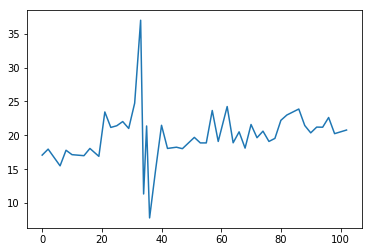

In [6]:
(evening_commutes['moving_time'] / pd.Timedelta(minutes=1)).plot()
plt.show()

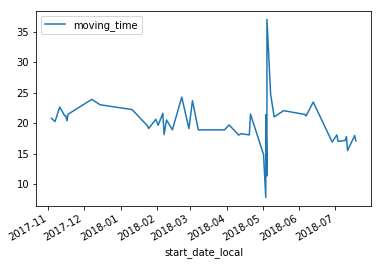

In [15]:
#to_plot = evening_commutes
#to_plot['moving_time'] = to_plot['moving_time'] / pd.Timedelta(minutes=1)
to_plot.plot(x='start_date_local', y='moving_time')
plt.show()

In [94]:
morning_commutes['end_latlng'].values

array(['33.78,-84.39', '33.77,-84.4', '33.77,-84.4', '33.77,-84.4',
       '33.78,-84.39', '33.77,-84.4', '33.79,-84.4', '33.77,-84.4',
       '33.79,-84.4', '33.79,-84.4', '33.79,-84.4', '33.79,-84.4',
       '33.79,-84.4', '33.79,-84.4', '33.78,-84.4', '33.78,-84.39',
       '33.78,-84.4', '33.79,-84.4', '33.78,-84.4', '33.78,-84.4',
       '33.78,-84.4', '33.78,-84.39', '33.78,-84.4', '33.78,-84.4',
       '33.79,-84.4', '33.79,-84.4', '33.78,-84.4', '33.78,-84.4',
       '33.79,-84.4', '33.79,-84.4', '33.77,-84.4', '33.78,-84.4',
       '33.79,-84.4', '33.79,-84.4', '33.79,-84.4', '33.78,-84.4',
       '33.78,-84.4', '33.78,-84.4', '33.78,-84.4', '33.78,-84.4',
       '33.78,-84.4', '33.79,-84.4', '33.79,-84.4', '33.78,-84.4',
       '33.78,-84.4'], dtype=object)

In [95]:
morning_commutes['end_latlng']

98    33.78,-84.39
97     33.77,-84.4
95     33.77,-84.4
91     33.77,-84.4
89    33.78,-84.39
87     33.77,-84.4
85     33.79,-84.4
83     33.77,-84.4
81     33.79,-84.4
77     33.79,-84.4
75     33.79,-84.4
73     33.79,-84.4
71     33.79,-84.4
69     33.79,-84.4
67     33.78,-84.4
65    33.78,-84.39
63     33.78,-84.4
61     33.79,-84.4
57     33.78,-84.4
54     33.78,-84.4
52     33.78,-84.4
50    33.78,-84.39
48     33.78,-84.4
46     33.78,-84.4
44     33.79,-84.4
42     33.79,-84.4
40     33.78,-84.4
38     33.78,-84.4
37     33.79,-84.4
35     33.79,-84.4
33     33.77,-84.4
31     33.78,-84.4
26     33.79,-84.4
24     33.79,-84.4
22     33.79,-84.4
20     33.78,-84.4
18     33.78,-84.4
16     33.78,-84.4
14     33.78,-84.4
12     33.78,-84.4
11     33.78,-84.4
9      33.79,-84.4
5      33.79,-84.4
3      33.78,-84.4
1      33.78,-84.4
Name: end_latlng, dtype: object